# **Phishing emails with GAN**
## **[Evangelos Argyropoulos](https://vaggelis-arg.github.io/) - Sapienza University of Rome (Erasmus student)**
## **Machine Learning Security - Professors Fabio De Gaspari & Dorjan Hitaj**

## Introduction

In the present project, I use existing datasets to train a classification model which distinguishes safe from phishing emails. Then I use a specific type of GAN which I am going to describe afterwards, so I can generate effective adversarial phishing-like emails which try to fool this classification model. This type of GAN is called SeqGAN and was introduced by Lantao Yu, Weinan Zhang, Jun Wang, and Yong Yu in their paper: [SeqGAN Paper](https://arxiv.org/pdf/1609.05473).

## Downloads

In [1]:
!pip install transformers==4.57.1 -U datasets==4.4.1 optuna scikit-learn nltk contractions emoji langdetect wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.9/263.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 112.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=eface29963e8c3c33d554fcc66f2ca28741bd33658f50f8f1cb95c2a72bb05bf
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect
  Attempting uninstal

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
import nltk
import emoji
import random
from nltk.tokenize import word_tokenize
import contractions
from langdetect import detect, LangDetectException
import torch
from datasets import load_dataset, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, AutoModelForCausalLM, AutoTokenizer, logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
import optuna
import kagglehub
import pickle
from wordcloud import WordCloud
from collections import Counter
import copy
import gc
from contextlib import nullcontext
logging.set_verbosity_error()
nltk.download(['punkt', 'wordnet','omw-1.4'])

2026-02-13 15:18:52.720410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770995932.909348      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770995932.960198      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770995933.399823      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770995933.399869      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770995933.399871      24 computation_placer.cc:177] computation placer alr

True

### Select device

In [3]:
def get_device():
    if torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    try:
        import torch_xla.core.xla_model as xm
        import torch_xla.utils.checkpoint as xla_checkpoint
        print("Using TPU")
        device = xm.xla_device()        
        torch.utils.checkpoint.checkpoint = xla_checkpoint.checkpoint
        return device
    except:
        pass
    print("Using CPU")
    return torch.device("cpu")

def autocast_(device):
    return torch.cuda.amp.autocast() if device.type == "cuda" else nullcontext()

device = get_device()

Using CUDA GPU


The notebook takes a lot of time to run (> 20 hours total), so I am going to use checkpoints, so we do not have to redo heavy computations again. I use Kaggle to run my notebook, and the solution I found is to create an input dataset (directory `/kaggle/input/`) where I place checkpoints (output files from previous runs) and save the results (new checkpoints) in the `/kaggle/working` directory.

In [4]:
PERSISTENT_DIR = "/kaggle/input/checkpoints"
WORKING_DIR = "/kaggle/working/checkpoints"
os.makedirs(WORKING_DIR, exist_ok=True)

def save_checkpoint(name, data):
    path = os.path.join(WORKING_DIR, f"{name}.pkl")
    with open(path, "wb") as f:
        pickle.dump(data, f)
    print(f"Checkpoint saved to: {path}")
    print("Current contents:", os.listdir(WORKING_DIR))

def load_checkpoint(name):
    for base in [WORKING_DIR, PERSISTENT_DIR]:
        path = os.path.join(base, f"{name}.pkl")
        if os.path.exists(path):
            with open(path, "rb") as f:
                print(f"Loaded checkpoint from: {path}")
                return pickle.load(f)
    print(f"No checkpoint found for {name}")
    return None

### Set seed for reproducibility

In [5]:
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if device.type == "cuda":
    torch.cuda.manual_seed_all(seed_value)

The data is the most important thing when it comes to building an effective model. This means that we need a dataset with very good quality and enough quantity to train our model properly. Through my search, I found a great dataset: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset which I am going to start with.

In [6]:
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /kaggle/input/phishing-email-dataset


['SpamAssasin.csv',
 'Nazario.csv',
 'Nigerian_Fraud.csv',
 'CEAS_08.csv',
 'Enron.csv',
 'Ling.csv',
 'phishing_email.csv']

We need to unify the dataframes into one and use only the columns we actually need (text & label), to train our model. The text has different name in each file. As text I define the $subject + body$ of the email. The labels are already $0$ (*for safe emails*) & $1$ (*for phishing emails*) in every file so we do not need to modify them.

## Custom function to filter columns

In [7]:
def filter_columns(df):
    if "subject" in df.columns and "body" in df.columns:
        df["text"] = (df["subject"].fillna("") + " " + df["body"].fillna(""))
    elif "text_combined" in df.columns:
        df["text"] = df["text_combined"].fillna("")
    
    return df[["text", "label"]]

## Read the dataset files & unify them into one

In [8]:
dfs = []

for file in os.listdir(path):
    file_path = os.path.join(path, file)
    df = pd.read_csv(file_path)
    df = filter_columns(df)
    dfs.append(df)

full_df = pd.concat(dfs, ignore_index=True)

#### We also need to shuffle the data so that the samples from all categories are distributed evenly

In [9]:
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

### Are there any duplicate emails?

In [10]:
full_df.duplicated().sum()

np.int64(420)

There are some duplicated tweets, we will remove them.

In [11]:
full_df = full_df[~full_df.duplicated()]

#### Are the classes balanced?

In [12]:
full_df.label.value_counts()

label
1    85729
0    78823
Name: count, dtype: int64

The classes look mostly balanced.

## Text Cleaning

Next, we define some custom functions to clean the email texts.

We use the DistilBERT transformer (Hugging face), which is a smaller pretrained version of BERT. Since DistilBERT is already a language model, it does not require heavy preprocessing. We do not want to damage the English words or the sentence structure, so we do not apply lemmatization, stopwords removal or punctuation removal.

In [13]:
# Lowercase characters
def lowercase_email(text):
    text = re.sub(r'\s+', ' ', text.lower())  # Replace whitespace characters with space, and convert to lowercase
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    text = ' '.join(word for word in text.split())
    return text

# Check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Collapse repeated punctuation to single instance
def collapse_repeated_punctuation(text):
    return re.sub(r'([.,!?;:-])\1+', r'\1', text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Replace links and mentions with the word 'link'
def replace_url_shorteners(text):
    return re.sub(r'(http|www|ftp|link|url|site|web|email|mail|tel|fax|phone)\S*', ' link ', text, flags=re.I)

# Remove spaces at the beginning and end of the email
def remove_spaces_email(text):
    return ' '.join(text.split()) 

# Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace="")

# Call all the cleaning functions in the correct order
def clean_email(email):
    email = replace_url_shorteners(email)
    email = strip_emoji(email)
    email = expand_contractions(email)
    email = filter_non_english(email)
    email = lowercase_email(email)
    email = remove_numbers(email)
    email = replace_elongated_words(email)
    email = collapse_repeated_punctuation(email)
    email = remove_spaces_email(email)
    return email

In [14]:
full_df['text_clean'] = full_df['text'].apply(clean_email)
full_df = full_df[full_df['text_clean'].str.strip() != '']

print(full_df.head(2).to_string(index=False))

## Data Plots

Now that we cleaned the data, we need to understand it and its distribution. We are going to plot word clouds & word frequencies for phishing and non-phishing emails to see which terms are most frequently used, token distribution plots to see how many words phishing and non-phishing emails have, and also the label distribution, to see once again (after we dropped the duplicates) whether the final dataset is balanced or not. This will define, to a large degree, how we will perform the training, as in unbalanced datasets we mostly use the F1-score in order to balance precision and recall.

In [15]:
phishing_df = full_df[full_df["label"] == 1]
safe_df = full_df[full_df["label"] == 0]

#### WordClouds

In [16]:
phishing_words = " ".join(phishing_df["text_clean"].dropna())
safe_words = " ".join(safe_df["text_clean"].dropna())

phishing_texts = phishing_df["text_clean"].dropna().tolist()
safe_texts = safe_df["text_clean"].dropna().tolist()

phishing_wc = WordCloud(width=1000, height=500, background_color="white", max_words=200).generate(phishing_words)

safe_wc = WordCloud(width=1000, height=500, background_color="white", max_words=200).generate(safe_words)

#### Top-N word frequency

In [17]:
def get_top_words(text_series, n=20):
    all_words = " ".join(text_series.dropna()).split()
    return Counter(all_words).most_common(n)

phishing_top = get_top_words(phishing_df["text_clean"])
safe_top = get_top_words(safe_df["text_clean"])

phishing_words, phishing_counts = zip(*phishing_top)
safe_words, safe_counts = zip(*safe_top)

### Plot everything in subplots

Demonstrate the dataset distribution and the features of the emails in plots & compute the max length of an email as we will need it later for the training process.

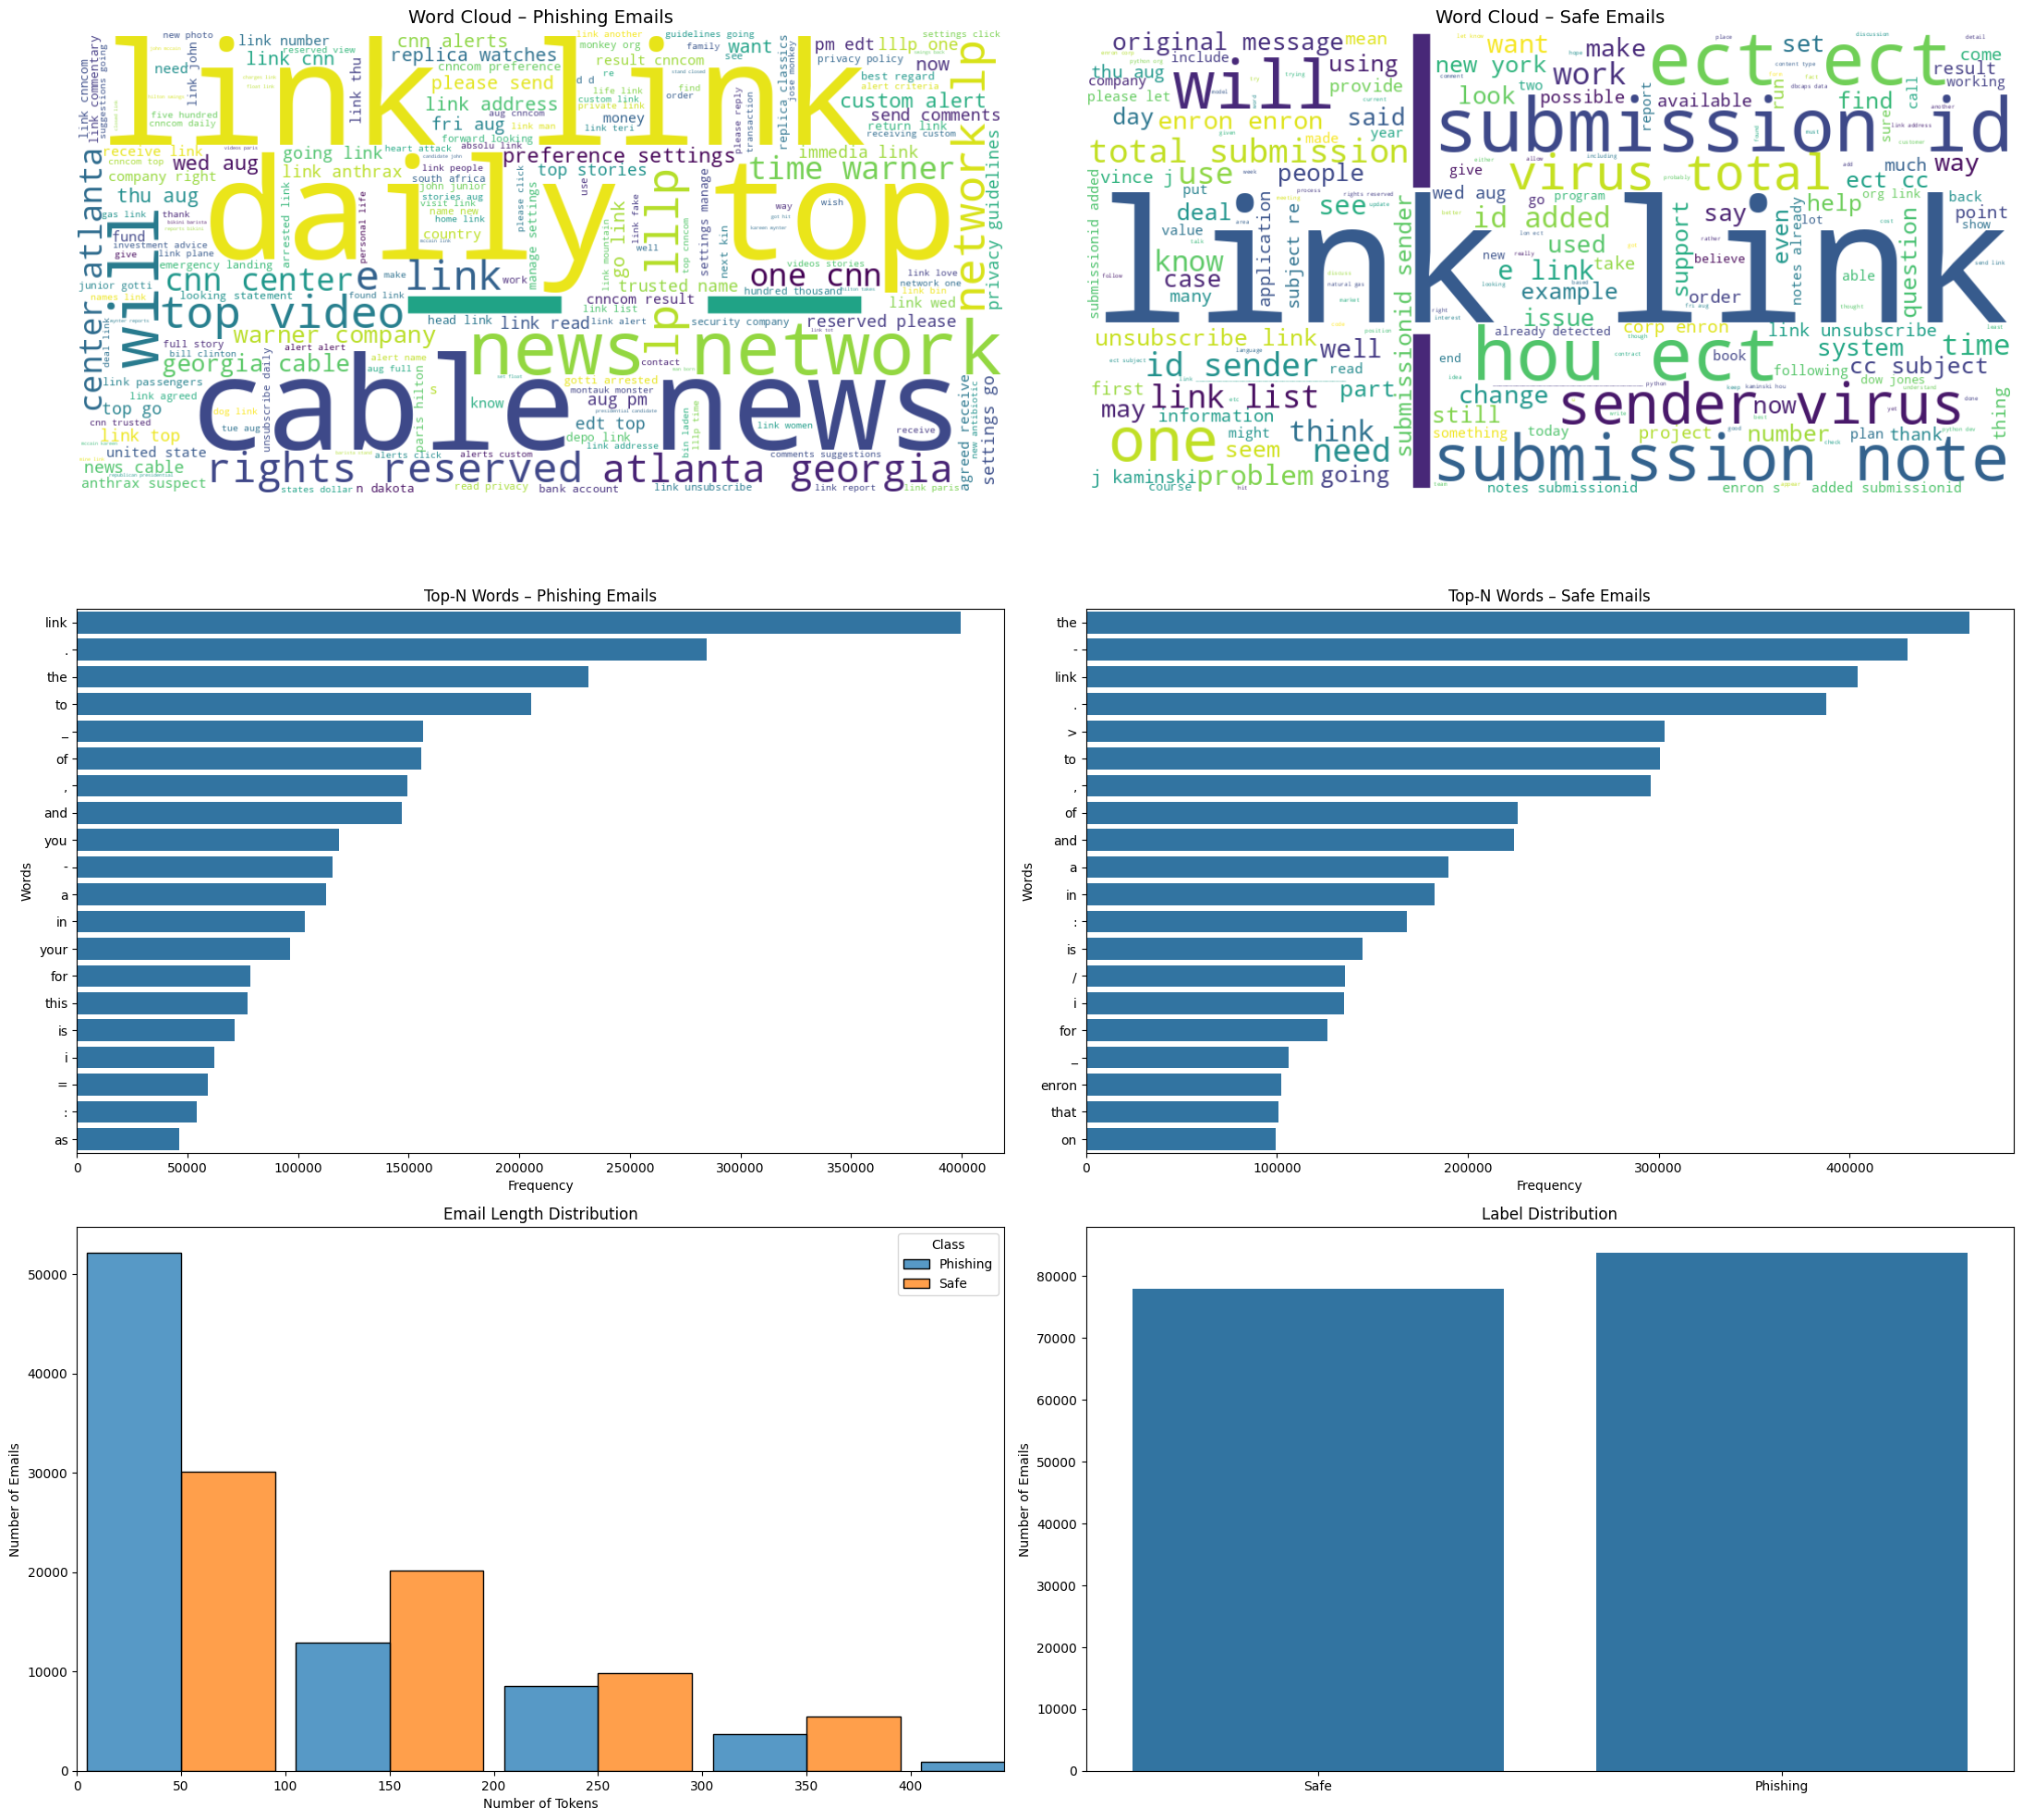

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(22, 20))

# Word Clouds
axes[0, 0].imshow(phishing_wc, interpolation="bilinear")
axes[0, 0].set_title("Word Cloud – Phishing Emails", fontsize=14)
axes[0, 0].axis("off")
axes[0, 1].imshow(safe_wc, interpolation="bilinear")
axes[0, 1].set_title("Word Cloud – Safe Emails", fontsize=14)
axes[0, 1].axis("off")

# Top-N word frequency
sns.barplot(x=list(phishing_counts), y=list(phishing_words), ax=axes[1, 0])
axes[1, 0].set_title("Top-N Words – Phishing Emails")
axes[1, 0].set_xlabel("Frequency")
axes[1, 0].set_ylabel("Words")
sns.barplot(x=list(safe_counts), y=list(safe_words), ax=axes[1, 1])
axes[1, 1].set_title("Top-N Words – Safe Emails")
axes[1, 1].set_xlabel("Frequency")
axes[1, 1].set_ylabel("Words")

# Email text size distribution
length_df = full_df.copy()
length_df["token_length"] = full_df["text_clean"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
length_df["Class"] = length_df["label"].map({0: "Safe", 1: "Phishing"})
mean_len = length_df["token_length"].mean()
length_df["dist_from_mean"] = (length_df["token_length"] - mean_len).abs()
cutoff = length_df["dist_from_mean"].quantile(0.90)
filtered_df = length_df[length_df["dist_from_mean"] <= cutoff] # Remove 10% most divergent from the mean
bin_width = 100
max_tokens = filtered_df["token_length"].max()
bins = range(0, int(max_tokens + bin_width), bin_width)
sns.histplot(data=filtered_df, x="token_length", hue="Class", bins=bins, multiple="dodge", shrink=0.9, ax=axes[2, 0])
axes[2, 0].set_xlim(0, max_tokens)
axes[2, 0].set_title("Email Length Distribution")
axes[2, 0].set_xlabel("Number of Tokens")
axes[2, 0].set_ylabel("Number of Emails")

# Label distribution
label_counts = full_df["label"].value_counts().sort_index()
sns.barplot(x=["Safe", "Phishing"], y=label_counts.values, ax=axes[2, 1])
axes[2, 1].set_title("Label Distribution")
axes[2, 1].set_ylabel("Number of Emails")

plt.tight_layout()
plt.show()

## Train - Test split

Now we need to split the dataset into a train and test sets.


In [19]:
X = full_df['text_clean']
y = full_df['label']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monitor the loss to avoid overfitting during the model training.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

## Tokenizer Initialization

DistilBert strictly allows a maximum of 512 tokens, but many of our emails are longer. We will chunk them later, but to silence warnings, I just set the tokenizer max length 1024 as this is the size we use as `max_length`.

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.model_max_length = int(1024)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Email Dataset Class

We need to feed the emails to the model, but before that, we have to turn the raw text into something the model can actually work with. This means tokenizing the emails so each one becomes a sequence of input_ids, along with an attention_mask that shows which tokens matter and which ones are just special or padding tokens. In the end, our dataset is transformed into `input_ids`, `attention_masks`, and `labels`. We also truncate very long emails to a maximum length of 1024 tokens, since we do not really care about emails that go far beyond that.

Actually, in the following implementation, it would have been more time efficient to tokenize everything once and store the encoding tensor in memory, but the RAM and disk space that Kaggle gives us are not enough to save such a big matrix all at once, so we tokenize each email only when we need it later.

In [23]:
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = torch.tensor(labels).long()
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, max_length=1024, padding=False, add_special_tokens=False)
        return {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

We will also need to group individual email samples into a single batch so the model can process them together during training, while keeping their input ids, attention masks, and labels aligned.

In [24]:
def collate_fn(batch):
    return {
        "input_ids": [item["input_ids"] for item in batch],
        "attention_mask": [item["attention_mask"] for item in batch],
        "labels": torch.stack([item["labels"] for item in batch])
    }

Now let's define the training and validation datasets.

In [25]:
train_dataset = EmailDataset(X_train.tolist(), y_train.tolist(), tokenizer)
val_dataset   = EmailDataset(X_val.tolist(), y_val.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, collate_fn=collate_fn)

#### Max length - DistilBERT

Unfortunately, DistilBERT can handle inputs of at most 512 tokens, while the dataset contains some emails that are much longer than that, even after the preprocessing step. Using only the first 512 tokens would lead to important information loss, which is something we want to avoid.

For this reason, what we are going to do is split each email into chunks of 512 tokens. For each chunk, we compute the logits corresponding to the phishing prediction, and at the end we take the mean of the logits across all chunks.

The following function takes an email (its input IDs and attention mask), splits it into chunks, passes each chunk through the model to get its logits, and finally returns the mean of all the chunks' logits. This way we get a single score for the whole email even if it is longer than 512 tokens.

In [26]:
def forward_email_chunks(model, input_ids, attention_mask, tokenizer=tokenizer, device=device):

    input_ids = torch.tensor(input_ids, dtype=torch.long).to(device)
    attention_mask = torch.tensor(attention_mask, dtype=torch.long).to(device)

    attention_mask = (attention_mask > 0).long()
    valid_len = int(attention_mask.sum().item())

    if valid_len == 0:
        # If all input_ids of the email are either special tokens (like CLS & SEP) or padding
        ids = torch.tensor([[cls_id, sep_id]], device=device, dtype=torch.long)
        mask = torch.tensor([[1, 1]], device=device, dtype=torch.long)
        # No need for chunking
        return model(input_ids=ids, attention_mask=mask).logits

    content_ids = input_ids[:valid_len]

    chunk_size = 510  # content tokens per chunk: 512 - 2 (CLS & SEP)
    chunk_logits = []

    for i in range(0, content_ids.size(0), chunk_size):
        chunk = content_ids[i:i + chunk_size]
        ids = torch.cat([
            torch.tensor([tokenizer.cls_token_id], device=device, dtype=torch.long),
            chunk,
            torch.tensor([tokenizer.sep_token_id], device=device, dtype=torch.long)
        ]).unsqueeze(0)

        mask = torch.ones_like(ids, dtype=torch.long, device=device)
        with autocast_(device):
            out = model(input_ids=ids, attention_mask=mask)
        chunk_logits.append(out.logits)

    # Consider fairly the logits of all chunks to return the prediction
    stacked = torch.stack(chunk_logits, dim=0)
    mean_logits = torch.mean(stacked, dim=0)

    return mean_logits

## Train function

In [27]:
def train_model(model, train_dataloader, val_dataloader, optimizer, epochs, device, patience=1):
    model.to(device)
    train_stats = {"train_loss": [], "val_loss": []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        if device.type == "cuda":
            torch.cuda.empty_cache()
        gc.collect() # garbage collector
        
        model.train()

        for batch in train_dataloader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"].to(device)
            logits_list = []
            with autocast_(device):
                for ids, mask in zip(input_ids, attention_mask):
                    logit = forward_email_chunks(model, ids, mask, tokenizer=tokenizer, device=device)
                    logits_list.append(logit)
        
                logits = torch.cat(logits_list, dim=0)
                loss = torch.nn.functional.cross_entropy(logits, labels)
        
            loss.backward()
            if device.type == 'xla':
                xm.optimizer_step(optimizer)
            else:
                optimizer.step()

        if val_dataloader is not None:
            val_metrics = evaluate_model(model=model, dataloader=val_dataloader, device=device)
            val_loss = val_metrics["loss"]
            train_stats["val_loss"].append(val_loss)
        else:
            val_loss = None
            train_stats["val_loss"].append(val_loss)

        train_metrics = evaluate_model(model, train_dataloader, device)
        train_loss = train_metrics["loss"]
        train_stats["train_loss"].append(train_loss)

        print(f"Epoch {epoch+1}: Train loss: {train_loss:.4f} | Val loss: {val_loss if val_loss is not None else 'N/A'}", flush=True)

        # early stopping
        if val_loss is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered.", flush=True)
                    break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_stats

## Evaluation function

In [28]:
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss, total_samples = 0.0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"].to(device)

            logits_list = []
            with autocast_(device):
                for ids, mask in zip(input_ids, attention_mask):
                    logit = forward_email_chunks(model, ids, mask, tokenizer=tokenizer, device=device)
                    logits_list.append(logit)

                logits = torch.cat(logits_list, dim=0)
                loss = torch.nn.functional.cross_entropy(logits, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            predictions = logits.argmax(dim=1)
            all_preds.extend(predictions.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    return {
        "loss": total_loss / total_samples,
        "accuracy": accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, average="weighted"),
        "precision": precision_score(all_labels, all_preds, average="weighted"),
        "recall": recall_score(all_labels, all_preds, average="weighted"),
        "confusion_matrix": confusion_matrix(all_labels, all_preds)
    }

## Optuna Objective Function

In the objective function, we will not use the whole training dataset (but only 40% of it), as we do not want to perform the actual training here. We just want to find the hyperparameter values that fit our model well. The main reason is that Optuna takes a lot of time and resources, and since it is not the primary task of the project, we reduce its scope.

We are going to use loss as the validation metric and try to minimize it while at the same time, we also care about how well the model generalizes, so we penalize trials where the gap between training loss and validation loss becomes too large.

$$
\text{score} = \text{validation\_loss} + \bigl(\text{penalty} \times \text{generalization\_gap}\bigr)
$$

In [29]:
def objective(trial):
    try:
        lr = trial.suggest_float("lr", 1e-6, 1e-4, log=True)
        dropout = trial.suggest_float("dropout", 0.4, 0.7)
        weight_decay = trial.suggest_float("weight_decay", 0.01, 0.2)
        epochs = trial.suggest_int("epochs", 1, 3)
    
        train_subset = Subset(train_dataset, list(range(int(0.4 * len(train_dataset)))))
        optuna_train_loader = DataLoader(train_subset, batch_size=8, collate_fn=collate_fn)
    
        model = DistilBertForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=len(set(y_train)), dropout=dropout
        ).to(device)
        model.gradient_checkpointing_enable()
    
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

        # DistilBert is an already trained transformer model, which means it easily overfits
        # Hence, we need to be careful
        train_model(model=model, train_dataloader=optuna_train_loader, val_dataloader=val_loader, optimizer=optimizer, epochs=epochs, device=device)
    
        val_metrics = evaluate_model(model=model, dataloader=val_loader, device=device)
        val_loss = val_metrics["loss"]
        train_metrics = evaluate_model(model=model, dataloader=optuna_train_loader, device=device)
        train_loss = train_metrics["loss"]
        gap = abs(val_loss - train_loss)
        return val_loss + 0.5 * gap
        
    except Exception as e:
        print("Trial failed with error:", e)
        raise
    finally:
        del model
        if device.type == "cuda":
            torch.cuda.empty_cache()
        gc.collect()

In [30]:
optuna_ckpt = load_checkpoint("optuna")
if optuna_ckpt is not None:
    best_params = optuna_ckpt["best_params"]
    print("Skipping Optuna, using saved best_params")
else:
    print("Running Optuna...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=2) # Optuna is very very expensive so we will do only 2 trials
    
    best_params = study.best_trial.params
    print("Best validation loss:", study.best_value)

    save_checkpoint("optuna", {"best_params": best_params})

print("Best parameters:")
print(best_params)

Loaded checkpoint from: /kaggle/input/checkpoints/optuna.pkl
Skipping Optuna, using saved best_params
Best parameters:
{'lr': 3.218984628003717e-06, 'dropout': 0.6969410732655925, 'weight_decay': 0.035006107677997174, 'epochs': 3}


## Train the model

Optuna provided the best hyperparameters it found during the study. We will use these parameters to define our model and train it.

In [31]:
final_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(set(y_train)),
    dropout=best_params["dropout"]
).to(device)
final_model.gradient_checkpointing_enable()

final_ckpt = load_checkpoint("final_model")
if final_ckpt is not None:
    final_model.load_state_dict(final_ckpt["model_state"])
    stats = final_ckpt["stats"]
    print("Loaded trained model, skipping training")
else:
    final_optimizer = AdamW(final_model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

    stats = train_model(
        model=final_model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        optimizer=final_optimizer,
        epochs=best_params["epochs"],
        device=device
    )
    save_checkpoint("final_model", {"model_state": final_model.state_dict(), "stats": stats})

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loaded checkpoint from: /kaggle/input/checkpoints/final_model.pkl
Loaded trained model, skipping training


## Evaluate the Model’s Performance on the Test Set

In [32]:
test_dataset  = EmailDataset(X_test.tolist(), y_test.tolist(), tokenizer)
test_loader  = DataLoader(test_dataset, batch_size=8, collate_fn=collate_fn)

test_metrics = evaluate_model(model=final_model, dataloader=test_loader, device=device)

print("Final Test Metrics:")
for k, v in test_metrics.items():
    if k != "confusion_matrix":
        print(f"{k}: {v:.4f}")

Final Test Metrics:
loss: 0.0520
accuracy: 0.9830
f1: 0.9830
precision: 0.9830
recall: 0.9830


## Learning curves

Learning curves allow us to inspect the behavior of the model across epochs and help us determine whether it is overfitting, underfitting, or learning appropriately.

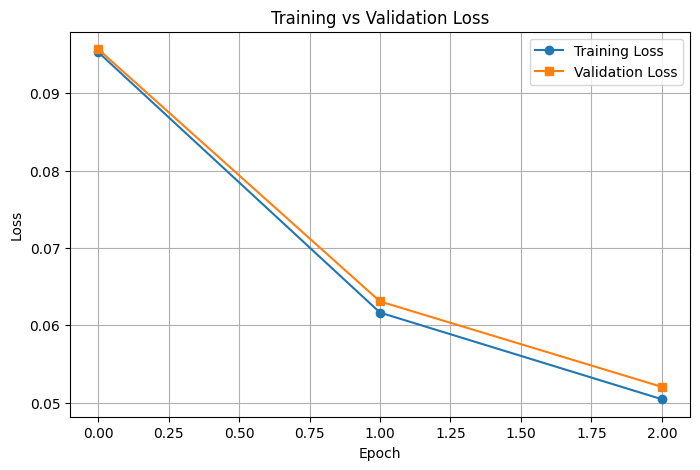

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(stats["train_loss"], label="Training Loss", marker="o")
plt.plot(stats["val_loss"], label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Confusion matrix

The confusion matrix allows us to see how many emails are correctly and incorrectly classified, showing true positives, true negatives, false positives, and false negatives.

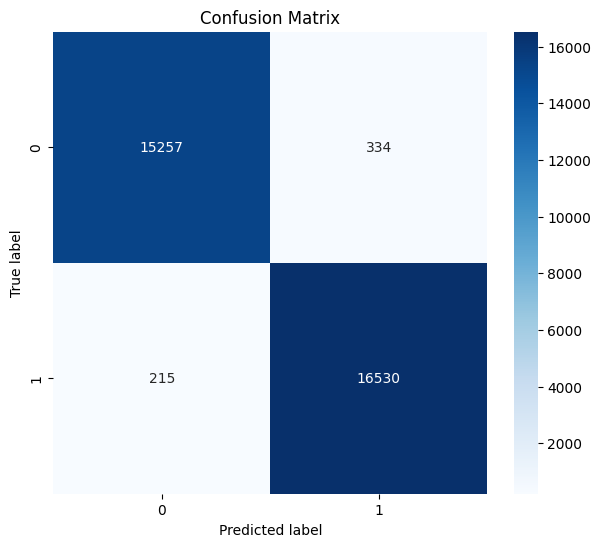

In [34]:
cm = test_metrics["confusion_matrix"]

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

### Freeze the Classifier

Now that we have a strong judge (our transformer classifier) to distinguish which emails are safe and which are phishing, we will freeze it, as from now on we will use it only for evaluation.

In [35]:
final_model.eval()
for p in final_model.parameters():
    p.requires_grad = False

## Generative Adversarial Networks (GAN)

The goal now is to generate effective adversarial phishing-like emails that can fool the classifier and be classified as safe. For this reason, we are going to use a Generative Adversarial Network composed of two models: a Generator (G) and a Discriminator (D). The generator is responsible for producing emails (as sequences of tokens), while the discriminator evaluates complete emails and estimates whether they look like real phishing emails or generated ones.

In a standard GAN, the generator starts from random noise $z$ and the discriminator is trained on real data so it can distinguish between real and generated samples. The two models are trained together by solving the following min–max problem:

$$
\min_G \max_D \; \mathbb{E}_{x \sim p_{\text{data}}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]
$$

This means that the generator tries to produce samples that are indistinguishable from real data, while the discriminator tries to become better at telling apart real and generated samples.

### But here we have a huge problem

This formulation works well for continuous data such as images, where small changes in the generator’s output lead to small changes in the discriminator’s response. In that case, gradients can flow smoothly from the discriminator back to the generator. Emails, however, are text. Text is discrete, composed of tokens, and there is no notion of continuity between words. Because of this, the generator cannot be updated through standard backpropagation, since sampling a token breaks the gradient flow.

To solve this issue, we should reformulate the problem using reinforcement learning. Instead of treating the generator as a differentiable function, we treat it as a policy $\pi_\theta$ that generates a sequence one token at a time. In this implementation, the discriminator acts as a reward function. After a full email $Y = (y_1, \dots, y_T)$ is generated, the discriminator assigns a scalar reward based on how realistic the email looks.

The objective of the generator then becomes:

$$
J(\theta) = \mathbb{E}_{Y \sim \pi_\theta}[D(Y)]
$$

and it is optimized using policy gradients:

$$
\nabla_\theta J(\theta) = \sum_{t=1}^{T} \mathbb{E}\left[ R_t \nabla_\theta \log \pi_\theta(y_t \mid y_{1:t-1}) \right] \quad (*)
$$

where $R_t$ is the expected reward at time step $t$, estimated via Monte Carlo rollouts. This means that token choices that lead to more realistic emails are reinforced, while poor choices are gradually suppressed.

Another important issue is the starting point of the generator. If the generator starts from pure random noise, it does not know English or phishing patterns, and the produced text will be mostly garbage. Even if such text could occasionally fool the classifier, it would not resemble realistic phishing texts. For this reason, the generator must first be pretrained on real phishing emails using a standard language modeling objective before adversarial training begins.

Finally, realism alone is not enough. Our goal is not only to generate realistic phishing emails, but also emails that can fool the classifier. To achieve this, we use two separate models for evaluation. The discriminator focuses on realism and phishing consistency, while the classifier evaluates whether the generated email is detected as phishing or safe. The outputs of both models are combined into the reward signal used to train the generator. This way, the generator is encouraged to produce emails that look realistic, use actual phishing techniques, and at the same time reduce the classifier’s confidence.

Do we already have a checkpoint for the SeqGAN loop? If yes, this can save us a lot of computational time, since we do not need to redo the generator and discriminator pretraining and we can skip all the SeqGAN loops up to the checkpoint.

In [36]:
seqgan_ckpt = load_checkpoint("seqgan")

Loaded checkpoint from: /kaggle/input/checkpoints/seqgan.pkl


## Generator

The generator must produce coherent text. It is not enough to simply output valid tokens. The full sequence should form an email text that actually makes sense. To achieve this, we use an LSTM Recurrent Neural Network model. The main reason is that LSTMs can keep track of what has already been generated and maintain context across longer sequences, which is essential in our case.

The generator starts from a special start token, predicts the next token, feeds it back to itself as input, and continues this process until a termination token is produced or a maximum sequence length is reached. In this way, an email is generated token by token.

Before starting the adversarial training, the generator is first pretrained using supervised learning on real phishing emails.

<!-- Note: A great video to explain how LSTM works is https://www.youtube.com/watch?v=YCzL96nL7j0&t=54s.
![LSTM](https://storage.googleapis.com/lightning-avatars/litpages/01hhda2ban5mpa8sa8gv0985cp/lstm_image.001.png) -->

In [37]:
phishing_subset = [text for text in phishing_texts if 32 <= len(tokenizer.tokenize(text)) <= 510]
gen_train_loader = DataLoader(EmailDataset(phishing_subset, [1]*len(phishing_subset), tokenizer), batch_size=8, collate_fn=collate_fn, shuffle=True)

Using custom embeddings is not a very good decision, because it would take much more time to train them and they would not achieve the same results as pretrained embeddings. The best and most convenient option for our case is to use DistilBERT pretrained word embeddings.

In [38]:
distilbert_embeddings = final_model.distilbert.embeddings.word_embeddings

In [39]:
class LSTMGenerator(torch.nn.Module):
    def __init__(self, distilbert_embeddings, hidden_dim=512, num_layers=2):
        super().__init__()
        self.embedding = distilbert_embeddings
        self.lstm = torch.nn.LSTM(input_size=distilbert_embeddings.embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.15)
        self.fc = torch.nn.Linear(hidden_dim, distilbert_embeddings.num_embeddings)
    def forward(self, input_ids, hidden=None):
        emb = self.embedding(input_ids)
        output, hidden = self.lstm(emb, hidden)
        logits = self.fc(output)
        return logits, hidden

generator = LSTMGenerator(distilbert_embeddings=distilbert_embeddings).to(device)
gen_optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, generator.parameters()), lr=7e-4)

As the generator should be able to create phishing emails, we need to pretrain it. Otherwise, SeqGAN will not work. The goal of this pretraining step is to maximize the likelihood of the next token given the previous ones.

Formally, the objective is:

$$
\max_\theta \sum_{t} \log P_\theta(x_t \mid x_{<t})
$$

In [40]:
def pretrain_generator(generator, dataloader, optimizer, epochs=15, patience=1):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    generator.train()
    best_loss = float('inf')
    patience_counter = 0
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        for batch in dataloader:
            # prepare input ids and add CLS/SEP to each sequence
            input_ids_list = []
            for ids in batch["input_ids"]:
                ids = list(ids)  # already token ids
                ids = [tokenizer.cls_token_id] + ids + [tokenizer.sep_token_id]
                input_ids_list.append(torch.tensor(ids, dtype=torch.long))

            input_ids = pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
            optimizer.zero_grad()
            logits, _ = generator(input_ids[:, :-1])
            loss = criterion(logits.reshape(-1, logits.size(-1)), input_ids[:, 1:].reshape(-1))
            loss.backward()
            if device.type == 'xla':
                xm.optimizer_step(optimizer)
            else:
                optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        avg_loss = total_loss / num_batches
        print(f"[Pretrain Generator] Epoch {epoch+1}: Loss {avg_loss:.4f}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

if seqgan_ckpt is None:
    pretrain_generator(generator, gen_train_loader, gen_optimizer)

Now that we have pretrained the generator, we need a way to actually generate emails. We start from a special start token and let the LSTM generator predict the next tokens one by one.

#### But how should we do that?

If we always pick the token with the highest logit value (argmax), the emails will be boring and very deterministic. Sometimes the generated email could even end up being almost the same as something from the training dataset.

If we pick the next token completely at random, for example sampling from the full multinomial distribution, the generator will often choose bad tokens and the emails will not make sense.

What we are going to do instead is **top‑k sampling**. At each step we keep only the k tokens with the highest probabilities and pick one of them according to their probability. This way the emails stay coherent and realistic, but also more diverse.

In [41]:
def get_punctuation_token_ids(tokenizer):
    punctuation_chars = ['.', ',', '!', '?', ':', ';', '-', '_', '*', '|', '/', '\\', '(', ')']
    token_ids = set()
    for p in punctuation_chars:
        ids = tokenizer.encode(p, add_special_tokens=False)
        if len(ids) == 1:
            token_ids.add(ids[0])
    return list(token_ids)

punct_ids = get_punctuation_token_ids(tokenizer)
punct_ids = torch.tensor(punct_ids, device=device)

def penalize_punctuation_logits(logits, punct_ids):
    if len(punct_ids) == 0:
        return logits
    logits[:, punct_ids] /= 1.5
    return logits


def generate_email(generator, tokenizer, min_len=64, max_len=512, top_k=12, device=device):
    """
    Generate one email using the current state of the generator
    """
    input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device, dtype=torch.long) # Start with CLS token
    hidden = None
    log_probs = []

    for t in range(max_len - 1):
        # LSTM forward pass (preserves hidden state for sequence generation)
        logits, hidden = generator(input_ids, hidden)

        # Keep only the final token's predictions
        next_logits = logits[:, -1, :].clone()

        # We do not want the same tokens to be repeated very close repeated very close to each other in the sequence
        if input_ids.size(1) >= 4:
            recent_tokens = input_ids[0, -4:].tolist()
            next_logits[0, recent_tokens] = -1e9

        next_logits = penalize_punctuation_logits(next_logits, punct_ids)
        
        topk = min(top_k, next_logits.size(-1))
        topk_vals, topk_idx = torch.topk(next_logits, topk, dim=-1)
        topk_probs = torch.softmax(topk_vals, dim=-1)
        
        sampled_in_topk = torch.multinomial(topk_probs, num_samples=1)
        token = topk_idx.gather(-1, sampled_in_topk)

        logp_full = torch.log_softmax(next_logits, dim=-1)
        log_prob = logp_full.gather(1, token).squeeze()
        log_probs.append(log_prob)

        # add new token in the sequence
        input_ids = torch.cat([input_ids, token], dim=1)
        
        # we allow early stopping only after min_len
        if t >= min_len and token.item() == tokenizer.sep_token_id:
            break

    # If the sequence does not end with SEP token, we insert it
    if input_ids[0, -1].item() != tokenizer.sep_token_id:
        sep_token = torch.tensor([[tokenizer.sep_token_id]], device=device)
        input_ids = torch.cat([input_ids, sep_token], dim=1)
        log_probs.append(torch.tensor(0.0, device=device))

    text = tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True)
    generator.train()
    return text, log_probs, input_ids

## Discriminator

The discriminator is basically a DistilBERT model, just like our classifier. Its job is simple: identify real phishing emails from the fake ones our generator creates. But here comes the problem. Since emails are discrete sequences, we cannot just backpropagate the gradients from the discriminator to the generator like in a normal GAN.  

The thing we do instead is treat the generator as a **policy in reinforcement learning** and the discriminator as a **reward function**. The discriminator gives feedback to the generator, showing which emails look real and which don’t.  

Now, one problem is that the generator produces emails token by token. If we feed the discriminator an unfinished email, it cannot give a proper reward. What we are going to do is use **Monte Carlo rollouts**. This means we finish the email multiple times using the generator, give the completed emails to the discriminator, and then compute the expected reward for the current token. This way, even partial emails get meaningful feedback.  

Mathematically, if the generator policy is $\pi_\theta$, the expected reward for a partial sequence $Y_{1:t} = (y_1, \dots, y_t)$ can be written as:

$$
\mathcal{R}_t = \frac{1}{N} \sum_{n=1}^N D(Y_{1:T}^{(n)})
$$

where $Y_{t+1:T}^{(n)} \sim \pi_\theta$ are the rollouts of the unfinished email and $D(Y_{1:T}^{(n)})$ is the discriminator output for the finished sample.  

Then we update the generator using a policy gradients $(*)$.

At first we should define and pretrain the discriminator as we did for the generator.

In [42]:
discriminator = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-6)

## Reward

To use reinforcement learning, we need to define a reward for the generator policy. This reward comes from two different models: the classifier and the discriminator. The classifier tells us how confident it is that an email is safe or phishing, while the discriminator tells us how confident it is that the email looks like a real phishing email and not a generated one.

We should always keep in mind the goal of this project. We want to generate phishing emails that are linguistically decent, human readable, and at the same time adversarial for a strong classifier. This means that the generated emails should look realistic and also confuse the classifier into thinking that they are safe.

Because we are working in a GAN setting and we care a lot about the phishing style of the email, we give more importance to the discriminator feedback than to the classifier feedback. The discriminator pushes the generator to produce phishing emails, while the classifier pushes it to make them harder to detect.

Let:
- $P_{\text{safe}} = P(\text{SAFE} \mid \text{email})$ be the probability given by the classifier
- $P_{\text{phish}} = P(\text{REAL PHISHING} \mid \text{email})$ be the probability given by the discriminator

We combine these two into a single reward as a weighted sum:

$$
R = \alpha \cdot P_{\text{phish}} + (1 - \alpha) \cdot P_{\text{safe}}
$$

where $\alpha \in [0, 1]$ controls how much importance we give to the discriminator compared to the classifier. In our case, we start with a higher value for $\alpha$ so that the generator first learns to produce realistic phishing emails, and as the epochs pass, we gradually lower it to give more importance to fooling the classifier.

This reward is then used to guide the generator during training, encouraging it to produce emails that look real and are also difficult for the classifier to correctly detect.

### But can the generator diverge from generating realistic emails while trying to learn phishing patterns and also fool the classifier?

Through the experiments, someone can easily understand that the structure of the emails is not good. I am not talking about the greeting and the ending part of the email, nor the subject, as these are not our main concerns here. The email samples contain tokens that do not actually fit English grammar and are often hard to understand in context. That is why I first use a low `top_k` value, since it is important that tokens with low probability should not get picked. I saw that the results are better, but still not sufficient, so I am going to use a “teacher” language model, GPT-2, to encourage, through a regularization factor beta, a higher reward for correct English texts.

In [43]:
lm_tokenizer = AutoTokenizer.from_pretrained("gpt2")
lm_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
lm_model.eval()

def lm_fluency_score(text, max_len=512):
    enc = lm_tokenizer(text, truncation=True, max_length=max_len, return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        loss = lm_model(**enc, labels=enc["input_ids"]).loss
    # return a higher score for more fluent text:
    return float(-loss)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

So, the actual reward is:

$$
R = \alpha \cdot P_{\text{phish}} + (1 - \alpha) \cdot P_{\text{safe}} + \beta \cdot P_{\text{linguistic}}
$$

In [44]:
def compute_reward(email_text, classifier, discriminator, tokenizer, device=device, alpha=0.65, beta=0.1):
    classifier.eval()
    discriminator.eval()
    enc = tokenizer(email_text, truncation=True, max_length=512, return_tensors="pt", return_attention_mask=True)
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)
    with torch.no_grad():
        clf_logits = classifier(input_ids=input_ids, attention_mask=attention_mask).logits
        disc_logits = discriminator(input_ids=input_ids, attention_mask=attention_mask).logits
        clf_probs = torch.softmax(clf_logits, dim=-1)
        disc_probs = torch.softmax(disc_logits, dim=-1)
        p_safe = clf_probs[0, 0]
        p_phish_style = disc_probs[0, 0]
    fluency = torch.exp(torch.tensor(lm_fluency_score(email_text), device=device))
    reward = alpha * p_phish_style + (1.0 - alpha) * p_safe + beta * fluency
    return 0.5 * (torch.tanh(reward) + 1.0)

## Monte Carlo Search

Now that we have a function to compute the reward for a full email, we need a way to pass this information back to the generator. The problem is that the reward comes only at the end, while the generator makes a choice at every token. So what we care about is how good each token choice actually was.

What we do is go through the generated email token by token. At position $t$, we freeze the prefix $y_{1:t}$ and from there we let the generator complete the rest of the email multiple (`rollout_num` variable) times. Each completion ends up as a full email, which we then score using the reward function.

This mean value is our estimate of how good the choice at position $t$ was, given everything that came before it. In other words, we approximate

$$
Q_t = \mathbb{E}_{Y_{t+1:T} \sim \pi_\theta} \left[ R(Y_{1:T}) \mid Y_{1:t} \right]
$$

These $Q_t$ values are then used directly in the policy gradient update. Even though the models only evaluate complete emails, this process lets us assign meaningful feedback to each token and slowly push the generator towards better and more convincing emails.

In [45]:
def get_hidden_from_prefix(generator, prefix):
    with torch.no_grad():
        _, hidden = generator(prefix)
    return hidden

def rollout_reward(generator, seq_ids, discriminator, classifier, tokenizer, rollout_num=5, max_len=512, top_k=12, alpha=0.65):
    """
    Monte Carlo estimation of token-wise rewards.
    For each token position t, freeze the prefix up to t, then sample multiple completions.
    Average reward across completions estimates Q-value for token at position t.
    """
    generator.eval()
    Q_values = []
    seq_ids = seq_ids.to(device)

    for t in range(1, seq_ids.size(1)):
        prefix = seq_ids[:, :t+1] # Get the prefix until the token t
        rewards = []
        hidden_base = get_hidden_from_prefix(generator, prefix)

        for _ in range(rollout_num):
            hidden = tuple(h.clone() for h in hidden_base) if isinstance(hidden_base, tuple) else hidden_base.clone()

            input_ids = prefix.clone()
            with torch.no_grad():
                # Complete the sequence till max_len or sep id
                while input_ids.size(1) < max_len:
                    logits, hidden = generator(input_ids[:, -1:], hidden)
                    next_logits = logits[:, -1, :].clone()
                    if input_ids.size(1) >= 4:
                        recent_tokens = input_ids[0, -4:].tolist()
                        next_logits[0, recent_tokens] = -1e9
                    next_logits = penalize_punctuation_logits(next_logits, punct_ids)
                    topk_vals, topk_idx = torch.topk(next_logits, min(top_k, next_logits.size(-1)))
                    probs = torch.softmax(topk_vals, dim=-1)
                    sampled = torch.multinomial(probs, 1)
                    next_token = topk_idx.gather(-1, sampled)
                    input_ids = torch.cat([input_ids, next_token], dim=1)
                    if next_token.item() == tokenizer.sep_token_id:
                        break
            text = tokenizer.decode(input_ids[0].tolist(), skip_special_tokens=True)
            r = compute_reward(text, classifier, discriminator, tokenizer, device=device, alpha=alpha)
            rewards.append(float(r))
        Q_values.append(sum(rewards) / len(rewards))
    generator.train()
    return Q_values

### Reinforce Update

Now we should create a function to update the generator by using the rewards to actually push the good tokens up and the bad ones down. The higher the reward, the more the generator learns to choose that token.

In [46]:
def reinforce_update(generator, optimizer, log_probs, Q_values):
    # REINFORCE loss: L = - mean( log_prob_t * Q_t )
    log_probs = torch.stack(log_probs)
    Q = torch.tensor(Q_values, device=log_probs.device, dtype=torch.float32)

    Q = (Q - Q.mean()) / (Q.std() + 1e-8)

    loss = -(log_probs * Q).mean()

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
    optimizer.step()

    return float(loss.item())

## Generator training step

First, we define how the generator learns in a single update step, following the SeqGAN paper.

In [47]:
def train_generator_rl_step(generator, discriminator, classifier, tokenizer, optimizer, device, alpha=0.65):
    """
    Training using RL with Monte Carlo rollouts. The algorithm is this:
    1) Generate an email token-by-token, storing per-token probabilities.
    2) Estimate quality of each token by exploring possible completions (rollouts).
    3) Update generator to favor tokens that lead to better emails.
    """
    
    # Produce sequence
    text, log_probs, seq_ids = generate_email(generator, tokenizer)

    # Monte Carlo rollouts for each token of the sequence
    Q_values = rollout_reward(generator, seq_ids, discriminator, classifier, tokenizer, alpha=alpha)

    # Policy gradient update
    loss = reinforce_update(generator, optimizer, log_probs, Q_values)

    return loss, sum(Q_values) / len(Q_values)

For each training epoch, this step is repeated `g_steps` times.

In [48]:
def train_generator_rl(generator, discriminator, classifier, tokenizer, optimizer, g_steps, device, alpha=0.65):
    generator.train()
    losses, rewards = [], []

    for _ in range(g_steps):
        loss, avg_reward = train_generator_rl_step(generator, discriminator, classifier, tokenizer, optimizer, device, alpha=alpha)
        losses.append(loss)
        rewards.append(avg_reward)

    return sum(losses)/len(losses), sum(rewards)/len(rewards)

## Discriminator training step

Now we need to define how the discriminator will be trained. As the GAN training moves forward, the generator keeps producing better emails, so the fake data seen by the discriminator should also change. At each training epoch, we generate a new batch of emails with the current generator and use them, together with real phishing emails, to retrain (from scratch) the discriminator so it always learns against the latest and strongest generator.

In [49]:
def train_discriminator_step(generator, discriminator, tokenizer, real_texts, optimizer, device):
    discriminator.train()

    # Un-freeze discriminator
    for p in discriminator.parameters():
        p.requires_grad = True

    # sample real subset
    real_subset = random.sample(real_texts, min(2000, len(real_texts)))
    fake_texts = []
    # Produce fake samples (2/3 of real as it is expensive to generate so many emails)
    with torch.no_grad():
        for _ in range(2 * len(real_subset) // 3):
            text, _, _ = generate_email(generator, tokenizer)
            fake_texts.append(text)

    all_texts = real_subset + fake_texts
    labels_list = [0] * len(real_subset) + [1] * len(fake_texts)  # 0=real phishing, 1=generated

    batch_size = 8
    criterion = torch.nn.CrossEntropyLoss(reduction="mean")

    total_loss = 0.0
    all_preds_prob, all_labels = [], []

    for i in range(0, len(all_texts), batch_size):
        batch_texts = all_texts[i:i+batch_size]
        batch_labels = torch.tensor(labels_list[i:i+batch_size], dtype=torch.long, device=device)

        batch_inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, add_special_tokens=True, return_tensors="pt")
        batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

        optimizer.zero_grad()
        logits = discriminator(**batch_inputs).logits

        loss = criterion(logits, batch_labels)
        loss.backward()
        if device.type == 'xla':
            xm.optimizer_step(optimizer)
        else:
            optimizer.step()

        total_loss += loss.item() * len(batch_texts)

        # probability of positive class (generated / phish style)
        probs = torch.softmax(logits, dim=-1)[:, 1].detach().cpu().numpy()
        all_preds_prob.extend(probs)
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(all_texts)
    preds_binary = (np.array(all_preds_prob) > 0.5).astype(int)
    acc = float(accuracy_score(all_labels, preds_binary))
    f1 = float(f1_score(all_labels, preds_binary, zero_division=0))

    print(f"[Discriminator step] loss={avg_loss:.6f} | accuracy={acc:.4f} | f1-score={f1:.4f}", flush=True)

    # Freeze again the discriminator (for RL phase)
    for p in discriminator.parameters():
        p.requires_grad = False
    discriminator.eval()

    return avg_loss, acc, f1

#### Pretrain Discriminator

In [50]:
if seqgan_ckpt is None:
    train_discriminator_step(
        generator=generator,
        discriminator=discriminator,
        tokenizer=tokenizer,
        real_texts=phishing_subset,
        optimizer=disc_optimizer,
        device=device
    )

## Reinforcement Learning Training Loop

The training loop is simple to describe. The generator creates emails, the discriminator trains on **real emails and the generated ones**. Each time the generator gets better, it produces better fake emails. Then we retrain the discriminator on these **new better fakes plus real emails**. We repeat this loop many times. Over time, both generator and discriminator improve, and the generator ends up producing emails that look very realistic.  

This is basically what SeqGAN does: the generator learns from the feedback of the discriminator (and in our case the classifier also) and keeps improving until the discriminator can hardly tell real from fake emails.

In [51]:
# Training hyperparams
num_epochs = 10
g_steps = 4

reward_history = []

start_epoch = 0
if seqgan_ckpt is not None:
    generator.load_state_dict(seqgan_ckpt["generator_state"])
    discriminator.load_state_dict(seqgan_ckpt["discriminator_state"])
    start_epoch = seqgan_ckpt["epoch"]
    reward_history = seqgan_ckpt["reward_history"]
    if start_epoch <= num_epochs:
        print(f"Resuming SeqGAN from epoch {start_epoch + 1}")
else:
    print("Starting SeqGAN from scratch")

for epoch in range(start_epoch, num_epochs):
    print(f"\n===== SEQGAN Epoch {epoch+1} =====")

    # Generator update
    generator.train()

    alpha = 0.9 - (epoch / (num_epochs - 1)) * (0.9 - 0.4)
    g_loss, g_reward = train_generator_rl(
        generator=generator,
        discriminator=discriminator,
        classifier=final_model,
        tokenizer=tokenizer,
        optimizer=gen_optimizer,
        g_steps=g_steps,
        device=device,
        alpha=alpha
    )
    
    generator.eval()

    print(f"[Generator] loss={g_loss:.4f} | reward={g_reward:.4f}")
    reward_history.append(g_reward)

    # Discriminator update
    train_discriminator_step(
        generator=generator,
        discriminator=discriminator,
        tokenizer=tokenizer,
        real_texts=phishing_subset,
        optimizer=disc_optimizer,
        device=device
    )

    if device.type == "cuda":
        torch.cuda.empty_cache()
    gc.collect()

    save_checkpoint("seqgan", {"generator_state": generator.state_dict(), "discriminator_state": discriminator.state_dict(), "epoch": epoch + 1, "reward_history": reward_history})

Resuming SeqGAN from epoch 10

===== SEQGAN Epoch 10 =====
[Generator] loss=-0.1058 | reward=0.5419
[Discriminator step] loss=0.157163 | accuracy=0.9418 | f1-score=0.9278
Checkpoint saved to: /kaggle/working/checkpoints/seqgan.pkl
Current contents: ['seqgan.pkl']


## Generator evaluation

Now that we have trained our generator model, we need to evaluate it, meaning how much it can fool the classifier. We will feed all the generated phishing emails to the classifier and see how would they be classified.

### Generator Reward Over Time

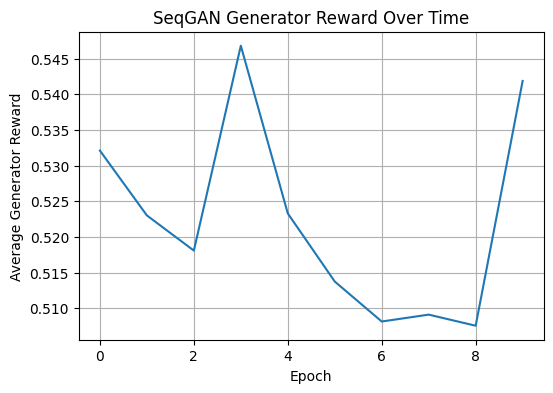

In [52]:
plt.figure(figsize=(6, 4))
plt.plot(reward_history)
plt.xlabel("Epoch")
plt.ylabel("Average Generator Reward")
plt.title("SeqGAN Generator Reward Over Time")
plt.grid(True)
plt.show()

### Generator metrics over strong classifier on 200 emails

In [53]:
def generate_emails(generator, tokenizer, n_samples=200, device=device):
    generator.eval()
    emails = []
    with torch.no_grad():
        for _ in range(n_samples):
            text, _, _ = generate_email(generator, tokenizer)
            emails.append(text)
    return emails

In [54]:
generated_emails = generate_emails(generator, tokenizer)
gen_dataset = EmailDataset(texts=generated_emails, labels=[1] * len(generated_emails), tokenizer=tokenizer)
gen_loader = DataLoader(gen_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [55]:
metrics = evaluate_model(final_model, gen_loader, device)

print("Classifier evaluation on generated emails:")
for k, v in metrics.items():
    if k != "confusion_matrix" and k != "loss":
        print(f"{k}: {v}")

Classifier evaluation on generated emails:
accuracy: 0.97
f1: 0.9847715736040609
precision: 1.0
recall: 0.97


### Generator Confusion Matrix

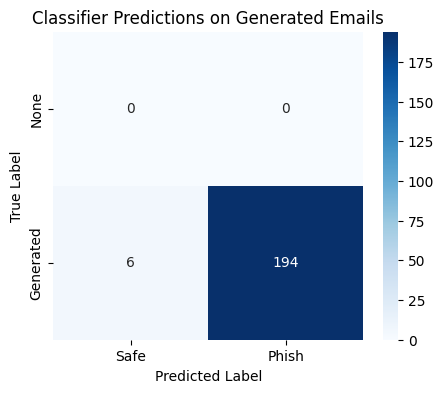

In [56]:
cm = metrics["confusion_matrix"]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Safe", "Phish"],
            yticklabels=["None", "Generated"])
plt.title("Classifier Predictions on Generated Emails")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

### Display 3 emails that successfully fool the classifier

In [57]:
def find_classifier_failures(model, emails, tokenizer, discriminator, device, max_print=3, alpha=0.8):
    model.eval()
    failures = []
    with torch.no_grad():
        for text in emails:
            inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            logits = forward_email_chunks(model, inputs["input_ids"][0], inputs["attention_mask"][0], tokenizer, device)
            probs = torch.softmax(logits, dim=-1)
            pred = torch.argmax(probs, dim=-1).item()
            
            if pred == 0:
                reward = compute_reward(text, model, discriminator, tokenizer, device=device, alpha=alpha)
                failures.append((text, probs[0, 0].item(), probs[0, 1].item(), reward))

    if not failures:
        print("No emails fooled the classifier with high reward. Here are 3 random generated emails for inspection:")
        random_samples = random.sample(emails, 3)
        for i, text in enumerate(random_samples, 1):
            print(f"Sample {i}: {text}")
    else:
        failures.sort(key=lambda x: x[3], reverse=True)
        failures = failures[:max_print]

    return failures

In [58]:
failed_emails = find_classifier_failures(final_model, generated_emails, tokenizer, discriminator, device, max_print=3, alpha=0.65)

print("\n=== Generated Emails That Fooled The Classifier ===\n")

for i, (email, p_safe, p_phish, reward) in enumerate(failed_emails, 1):
    print(f"--- Example {i} ---")
    print(f"Classifier → Safe: {p_safe:.4f} | Phish: {p_phish:.4f} | Reward: {reward:.4f}")
    print("\nEMAIL CONTENT:\n")
    print(email)
    print("\n" + "="*80 + "\n")


=== Generated Emails That Fooled The Classifier ===

--- Example 1 ---
Classifier → Safe: 0.6157 | Phish: 0.3845 | Reward: 0.6162

EMAIL CONTENT:

daily top lobby tails cadet oequatable wysasws per - flat piece station trip link addthemertructopp com briskon listing net brrak still good possible voice link contains every day boat like know one another day boat starts good let know like see make good day please see talk know good make work please always go talk hear going get chance talk link see animations want link soon get paid really meet talk someone go noun miss jumping talk little hear soon hope answer thank god bless wanted chance talk god bless regards simon


--- Example 2 ---
Classifier → Safe: 0.6323 | Phish: 0.3679 | Reward: 0.6049

EMAIL CONTENT:

re : tendency what can't go through. i think you are a good time, but you can talk at the - language from a who are the same way in your own boss, or you did to talk ; i can meet the word. what is a thing, it is what he did. it 

## Conclusion

This project was a custom idea, since my professors gave me the opportunity to choose my own topic. Through the Machine Learning Security course, I learned many different things. I worked with adversarial examples by adding perturbations to data using methods like FGSM, PGD, and Carlini–Wagner, and I also learned how to defend against these attacks with adversarial training. I studied more general attacks such as Adversarial Patches and Universal Adversarial Perturbations. I explored Explainable AI, both on a global level using surrogate models and on a local level using LIME to explain individual decisions. I learned how to understand which features actually matter through partial dependence plots and SHAP values. I also covered topics like certified robustness, hidden Markov models, model inversion, model extraction, attacks in federated learning, and backdoor and poisoning attacks.

Out of all these, what I liked the most was GANs. I also did a presentation on GANs in federated learning inference attacks. For this project, I wanted to combine GANs with a cybersecurity problem, and since I had already worked with NLP before, I chose phishing emails.

I faced several challenges during the assignment. The biggest one was the computational time. Each run of the notebook took many hours, and I could not know if something was wrong in the code until the whole run finished. On top of that, Kaggle limits a single notebook session to about 12 hours, while my full pipeline needed much more time. To deal with this, I used checkpoints so I could continue from intermediate stages instead of starting from scratch every time.

Another important challenge was finding good quality data. As we all know, the dataset is one of the most important parts of any machine learning project, so I spent time searching for a dataset that was both large enough and reliable for this task.

On the technical side, I had to deal with very long emails. I did not want to remove them, because that would mean losing useful information. I first tried using the Longformer-4096 model, which fits this kind of data very well, but the training time was too high for the resources I had. For this reason, I used DistilBERT. To make this work with long emails, I implemented a chunking approach, where each email is split into smaller parts, passed through the model, and the logits from all chunks are combined by taking their mean to compute the final prediction and loss.

After training DistilBERT, I noticed behavior that looked like overfitting in the learning curves, since the training metrics kept improving steadily. This is not surprising for a large pretrained model with many parameters. I tried to control this by looking at the generalization gap, increasing weight decay, adjusting dropout, and using early stopping. Even then, the training curve did not really degrade. In any case, the final model achieved strong performance and acted as a reliable classifier for the next stages of the project.

The next difficult part was reinforcement learning. The vocabulary size of the DistilBERT embeddings is around 30,000 tokens, which means that without any pretraining, the loss starts very high ($\approx 10.3$) and the generated text is mostly repeated punctuation and meaningless tokens. After pretraining the generator on a subset of real phishing emails, I managed to bring the loss down ($ < 2.5$) and the generated emails started to look more reasonable. During reinforcement learning, however, the generator started to prioritize phishing patterns and classifier fooling, sometimes at the expense of linguistic quality, so I introduced an additional language-based signal in the reward to encourage more fluent and human-readable emails.

At this point, I also had to decide how to balance the importance between producing strong phishing-style emails and actually fooling the classifier. My approach was to first make sure that the generator learns the phishing patterns as a baseline, and then, as training progresses, gradually give more importance to the classifier’s mistakes.

Overall, building the SeqGAN pipeline was not easy, but I tried to follow the original paper as closely as possible. The training loop was based on generating a full email, and then, for each token, using Monte Carlo search to estimate how good that choice was given the context. These estimates were then used to update the generator so that better token choices become more likely over time.

I used Monte Carlo search because that is what the paper suggests, but one possible next step would be to move to an [Actor-Critic approach](https://arxiv.org/pdf/1607.07086), which could be more efficient. Another extension would be to apply a LIME-style surrogate model to the classifier, so for each generated email that fools it, we can also understand which parts of the text influenced the decision the most. As a defense, the generated emails could then be used for **adversarial training** to further improve the classifier.

Throughout this project, I mainly followed the [SeqGAN paper](https://arxiv.org/pdf/1609.05473), looked at other structured notebooks such as the [Detecting bullying Tweets project](https://www.kaggle.com/code/ludovicocuoghi/detecting-bullying-tweets-pytorch-lstm-bert) on Kaggle, and used AI tools mostly for fixing Python syntax and improving the markdown and language of the report.